In [1]:
print("Multimedia Security Experiment 15")

Multimedia Security Experiment 15


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import myipf # 前面的实验编写的函数
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline
plt.rcParams["font.sans-serif"] = ["SimHei"] # 用来正常显示中文
plt.rcParams["axes.unicode_minus"] = False # 用来正常显示负号
%config InlineBackend.figure_format = "svg"

## DCT域信息隐藏

读入图像

In [57]:
img = cv.imread("standard_test_images/lena_color_256.tif")
logo= cv.imread("test.png")

### 嵌入信息
图像预处理以及LOGO信息预处理，之后再把信息嵌入到图像中去  
选择中频区域嵌入信息，p1和p2成中心对称

In [64]:
def dctWatermark(src, logo, d=0.1):
    # LOGO 预处理
    # 信息为二值图像，先去除下噪声，然后二值化，再缩放尺寸为(100, 50)，最后拉伸成向量
    gray_logo = cv.cvtColor(logo, cv.COLOR_BGR2GRAY)
    gray_logo = cv.medianBlur(gray_logo, 3)
    ret, bin_logo = cv.threshold(gray_logo, 70, 1, cv.THRESH_BINARY)
    bin_logo = cv.resize(bin_logo, (100, 50))
    vec_logo = bin_logo.flatten()
    
    # 宿主图像预处理，RGB格式转化为YUV格式，uint8转为float32类型，
    b2y_img = cv.cvtColor(src, cv.COLOR_BGR2YUV)
    yuv_img = b2y_img.astype(np.float32)
    # 8✖️8分块，l为计数变量
    row, col, l = int(np.floor(src.shape[0]/8)), int(np.floor(src.shape[1]/8)), 0
    info_count = 5000 # bin_logo.shape[0] * bin_logo.shape[1] # 要嵌入的信息量
    block_bits = int(np.ceil(info_count / (row*col))) # 宿主图像的8✖️8小块平均要嵌入多少比特的信息
    # 储存中间结果的图像和目标图像先全部置0
    tmp_dct = np.zeros((img.shape[0], img.shape[1]), np.float32)
    dst_img = np.zeros((img.shape[0], img.shape[1]), np.float32)
    for i in range(row):
        for j in range(col):
            part = cv.dct(yuv_img[8*i:8*i+8, 8*j:8*j+8, 0])
            k    = 0
            while k < block_bits and l < info_count:
                px, py = 6-k, 0+k
                p1 = part[px, py]
                p2 = part[7-px, 7-py]
                tmp_d  = float(np.abs(p1-p2) + d)
                if vec_logo[l] == 0:
                    if (p1 < p2):
                        part[px, py], part[7-px, 7-py] = part[7-px, 7-py], part[px, py]
                    part[px, py] += d
                    part[7-px, 7-py] -= d        
                else:
                    if (p1 > p2):
                        part[px, py], part[7-px, 7-py] = part[7-px, 7-py], part[px, py]
                    part[px, py] -= d
                    part[7-px, 7-py] += d 
                l += 1
                k += 1
            tmp_dct[8*i:8*i+8, 8*j:8*j+8] = part
            dst_img[8*i:8*i+8, 8*j:8*j+8] = cv.idct(part)
    # 转换为RGB格式
    dst_img = cv.merge([dst_img.astype(np.uint8), b2y_img[:,:,1], b2y_img[:,:,2]])
    dst_img = cv.cvtColor(dst_img, cv.COLOR_YUV2BGR)
    return (tmp_dct, dst_img)

### 提取水印
因为嵌入时强制要求水印尺寸为(100, 50)，所以提取函数只需要嵌入水印后的图像即可实现盲水印提取

In [93]:
def getDctWatermark(src):
    dst_logo = np.zeros((5000, 1), np.float32)
    tmp_img  = cv.cvtColor(src, cv.COLOR_BGR2YUV).astype(np.float32)
    # 8✖️8分块，l为计数变量
    row, col, l = int(np.floor(src.shape[0]/8)), int(np.floor(src.shape[1]/8)), 0
    info_count  = 5000
    block_bits  = int(np.ceil(info_count / (row*col)))
    for i in range(row):
        for j in range(col):
            part = cv.dct(tmp_img[8*i:8*i+8, 8*j:8*j+8, 0])
            k    = 0
            while k < block_bits and l < info_count:
                px, py = 6-k, 0+k
                p1 = part[px, py]
                p2 = part[7-px, 7-py]
                if p1 > p2:
                    dst_logo[l] = 0
                else:
                    dst_logo[l] = 255
                l += 1
                k += 1
    return dst_logo.reshape(50, 100)

## 使用参数d=1进行实验

In [66]:
tmp_img, info_img = dctWatermark(img, logo, d=1)

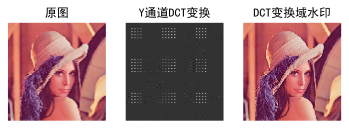

均方差： 9.313603719075521
峰值信噪比： 38.43962605506123


In [67]:
plt.subplot(1, 3, 1), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.axis("off"), plt.title("原图")
plt.subplot(1, 3, 2), plt.imshow(tmp_img, cmap="gray"), plt.axis("off"), plt.title("Y通道DCT变换")
plt.subplot(1, 3, 3), plt.imshow(cv.cvtColor(info_img, cv.COLOR_BGR2RGB)), plt.axis("off"), plt.title("DCT变换域水印")
plt.show()
myipf.calcMSEPSNR(img, info_img)

### 提取水印

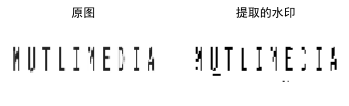

In [77]:
plt.subplot(1, 2, 1), plt.imshow(cv.resize(logo, (100, 50)), cmap="gray"), plt.axis("off"), plt.title("原图")
plt.subplot(1, 2, 2), plt.imshow(getDctWatermark(info_img), cmap="gray"), plt.axis("off"), plt.title("提取的水印")
plt.show()

## 使用参数d=3进行实验

In [78]:
tmp_img2, info_img2 = dctWatermark(img, logo, d=3)

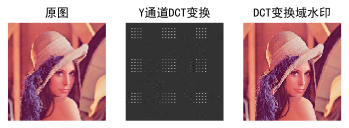

均方差： 9.313603719075521
峰值信噪比： 38.43962605506123


In [79]:
plt.subplot(1, 3, 1), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.axis("off"), plt.title("原图")
plt.subplot(1, 3, 2), plt.imshow(tmp_img2, cmap="gray"), plt.axis("off"), plt.title("Y通道DCT变换")
plt.subplot(1, 3, 3), plt.imshow(cv.cvtColor(info_img2, cv.COLOR_BGR2RGB)), plt.axis("off"), plt.title("DCT变换域水印")
plt.show()
myipf.calcMSEPSNR(img, info_img)

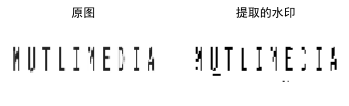

In [80]:
plt.subplot(1, 2, 1), plt.imshow(cv.resize(logo, (100, 50)), cmap="gray"), plt.axis("off"), plt.title("原图")
plt.subplot(1, 2, 2), plt.imshow(getDctWatermark(info_img), cmap="gray"), plt.axis("off"), plt.title("提取的水印")
plt.show()

In [98]:
# 临时函数，不只输出PSNR，还作为返回值
def calcMSEPSNR(image1, image2):
    M = image1 - image2
    MSE = np.sum(M.flatten() * M.flatten()) / np.size(image1)    
    #SNR = 10 * np.log10(np.sum(image1.flatten() * image1.flatten()) / MSE / np.size(image2))
    if MSE == 0:
        PSNR = "inf";
    else:
        PSNR = 10 * np.log10((255 ** 2) / MSE)
    print("均方差：", MSE)
    print("峰值信噪比：", PSNR)
    return (MSE, PSNR)

## 鲁棒性测试d=1
采用JPEG压缩，质量由100减少到91，看提取的水印与原水印的PSNR

In [112]:
psnr1 = []
for i in range(10):
    file_name = "tmp/" + hex(i) + ".jpg"
    cv.imwrite(file_name, info_img, [int(cv.IMWRITE_JPEG_QUALITY), 100-i])
    tmp_img = plt.imread(file_name)
    tmp_logo = getDctWatermark(tmp_img)
    psnr1.append(calcMSEPSNR(cv.resize(logo, (100, 50))[:,:,0], tmp_logo)[1])

均方差： 514.872
峰值信噪比： 21.013810863957723
均方差： 585.201
峰值信噪比： 20.45775301285261
均方差： 795.321
峰值信噪比： 19.1253791096424
均方差： 1822.359
峰值信噪比： 15.524464249154025
均方差： 4411.476
峰值信噪比： 11.684964400153305
均方差： 7778.088
峰值信噪比： 9.222075084928012
均方差： 9612.252
峰值信噪比： 8.30255212887647
均方差： 12868.1944
峰值信噪比： 7.03562747695364
均方差： 14791.4544
峰值信噪比： 6.430694818784608
均方差： 16124.8496
峰值信噪比： 6.055846883013612


## 鲁棒性测试d=3
采用JPEG压缩，质量由100减少到91，看提取的水印与原水印的PSNR

In [113]:
psnr2 = []
for i in range(10):
    file_name = "tmp/" + hex(i) + ".jpg"
    cv.imwrite(file_name, info_img2, [int(cv.IMWRITE_JPEG_QUALITY), 100-i])
    tmp_img = plt.imread(file_name)
    tmp_logo = getDctWatermark(tmp_img)
    psnr2.append(calcMSEPSNR(cv.resize(logo, (100, 50))[:,:,0], tmp_logo)[1])

均方差： 331.731
峰值信噪比： 22.922943029756212
均方差： 344.736
峰值信噪比： 22.755937227022688
均方差： 331.731
峰值信噪比： 22.922943029756212
均方差： 331.731
峰值信噪比： 22.922943029756212
均方差： 331.833
峰值信噪比： 22.921607874820047
均方差： 435.873
峰值信噪比： 21.73720393236287
均方差： 731.622
峰值信噪比： 19.48793604557041
均方差： 2170.791
峰值信噪比： 14.764623485217578
均方差： 4091.91
峰值信噪比： 12.011542878642526
均方差： 6495.846
峰值信噪比： 10.004446405311892


## 鲁棒性测试d=5

In [114]:
tmp_img3, info_img3 = dctWatermark(img, logo, d=5)
psnr3 = []
for i in range(10):
    file_name = "tmp/" + hex(i) + ".jpg"
    cv.imwrite(file_name, info_img3, [int(cv.IMWRITE_JPEG_QUALITY), 100-i])
    tmp_img = plt.imread(file_name)
    tmp_logo = getDctWatermark(tmp_img)
    psnr3.append(calcMSEPSNR(cv.resize(logo, (100, 50))[:,:,0], tmp_logo)[1])

均方差： 305.823
峰值信噪比： 23.276102166213605
均方差： 305.823
峰值信噪比： 23.276102166213605
均方差： 305.823
峰值信噪比： 23.276102166213605
均方差： 318.828
峰值信噪比： 23.0952390601237
均方差： 305.823
峰值信噪比： 23.276102166213605
均方差： 305.823
峰值信噪比： 23.276102166213605
均方差： 305.823
峰值信噪比： 23.276102166213605
均方差： 305.823
峰值信噪比： 23.276102166213605
均方差： 318.828
峰值信噪比： 23.0952390601237
均方差： 422.766
峰值信噪比： 21.86980307980228


### 输出最后一次提取的水印图像

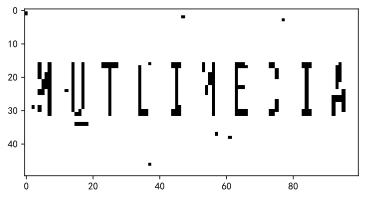

In [115]:
plt.imshow(tmp_logo, cmap="gray")

## 总结

In [120]:
xd = [100, 99, 98, 97, 96, 95, 94, 93, 92, 91]
n = len(xd)
B = np.array(psnr1[:])
C = np.array(psnr2[:])
D = np.array(psnr3[:])
A = np.array(([[xd[j], 1] for j in range(n)]))
X = np.linalg.lstsq(A, B, rcond=None)[0]
Y = np.linalg.lstsq(A, C, rcond=None)[0]
Z = np.linalg.lstsq(A, D, rcond=None)[0]
a = X[0]
b = X[1]
print("d=1：", "y =", a, "x +", b)
c = Y[0]
d = Y[1]
print("d=3：", "y =", a, "x +", b)
e = Z[0]
f = Z[1]
print("d=5：", "y =", a, "x +", b)

d=1： y = 1.9235664668271197 x + -171.2152807791583
d=3： y = 1.9235664668271197 x + -171.2152807791583
d=5： y = 1.9235664668271197 x + -171.2152807791583


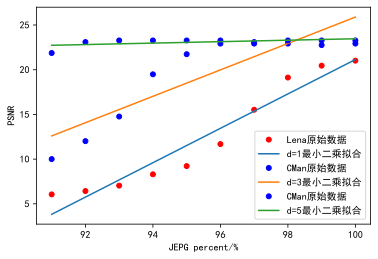

In [124]:
plt.plot(np.array(xd), B, "ro", label = "Lena原始数据", markersize = 5)
plt.plot(np.array(xd), a * np.array(xd) + b, label = "d=1最小二乘拟合")
plt.plot(np.array(xd), C, "bo", label = "CMan原始数据", markersize = 5)
plt.plot(np.array(xd), c * np.array(xd) + d, label = "d=3最小二乘拟合")
plt.plot(np.array(xd), D, "bo", label = "CMan原始数据", markersize = 5)
plt.plot(np.array(xd), e * np.array(xd) + f, label = "d=5最小二乘拟合")
plt.legend()
plt.xlabel("JEPG percent/%")
plt.ylabel("PSNR")
plt.show()

### 
可以看到d越大，鲁棒性越强，我们再来看下图像质量，可以看到PSNR只有29dB，不可觉察降低了

均方差： 80.26772054036458
峰值信噪比： 29.08539430902197


(80.26772054036458, 29.08539430902197)

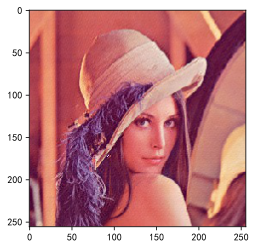

In [127]:
tmp_img = plt.imread("tmp/0x9.jpg") # JEPG存储质量91%
plt.imshow(tmp_img)
calcMSEPSNR(tmp_img, img)